## Jack's Car Rental - Modified
This is the 4.7 exercise from the RL book.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math

## Initialization

In [2]:
# Technically, there will be infinite s', but we limited it to 20.

SIZE = 20
states = np.zeros((SIZE+1,SIZE+1)) # Given a pair of state, what is its state value?
policy = np.zeros((SIZE+1,SIZE+1)) # Given a pair of state, what is the action to take? (Always deterministic)
theta = 0.1 # Greatly affect the calculation speed
gamma = 0.9

LAM_REQ1, LAM_REQ2, LAM_RET1, LAM_RET2 = 3,4,3,2

# No need for 0 - 20, because the pmf is really low.
REQ1_MAX = 9
REQ2_MAX = 11
RET1_MAX = 9
RET2_MAX = 7

In [3]:
# Expensive to calculate at every run - cache the results for given lambda.
poisson_cache = {}

def poisson_pmf(lam, n):
    key = (lam, n)
    if key not in poisson_cache:
        poisson_cache[key] = math.exp(-lam) * lam**n / math.factorial(n)
    return poisson_cache[key]

def precompute_poisson():
    for n in range(max(REQ1_MAX, RET1_MAX)):
        poisson_pmf(LAM_REQ1, n)
        poisson_pmf(LAM_RET1, n)
    for n in range(max(REQ2_MAX, RET2_MAX)):
        poisson_pmf(LAM_REQ2, n)
        poisson_pmf(LAM_RET2, n)

## Evaluation

In [4]:
def gather_value(state, action):
    s1, s2 = state

    # Optimization: since (s,a) does not change, we could calculate 
    # 1. part of the "new state" (the action part, not including the return)
    # 2. part of reward (the -2 part)
    # 3. pre-compute and cache the poisson calculations

    s1_prime, s2_prime = min(20, max(0, s1-action)), min(20, max(0, s2+action))
    v_s = 0
    if action > 0:
        v_s = -2 * (action-1)
    else:
        v_s = -2 * abs(action)

    # Use fixed bounds covering Poisson distributions
    for req1 in range(REQ1_MAX):
        for req2 in range(REQ2_MAX):
            for ret1 in range(RET1_MAX):
                for ret2 in range(RET2_MAX):

                    p = calculate_prob(req1, req2, ret1, ret2)

                    rent1, rent2 = min(req1, s1_prime), min(req2, s2_prime)
                    reward = (rent1 + rent2) * 10
                    new_s1 = max(min(s1_prime - rent1 + ret1, 20),0)
                    new_s2 = max(min(s2_prime - rent2 + ret2, 20),0)
                    if new_s1 > 10:
                        reward -= 4
                    if new_s2 > 10:
                        reward -= 4
                    
                    v_s += p * (reward + gamma * states[int(new_s1), int(new_s2)])
    return v_s

# The probability of the request and return values
def calculate_prob(req1, req2, ret1, ret2):
    p1 = poisson_pmf(LAM_REQ1, req1)
    p2 = poisson_pmf(LAM_REQ2, req2)
    p3 = poisson_pmf(LAM_RET1, ret1)
    p4 = poisson_pmf(LAM_RET2, ret2)
    return p1 * p2 * p3 * p4

In [5]:
def policy_evaluation():
    break_loop = False
    while not break_loop:
        change = 0
        for i in range(SIZE+1):
            for j in range(SIZE+1):
                prev_state = states[i,j]
                states[i,j] = gather_value([i,j], policy[i,j]) 
                change = max(change, abs(prev_state - states[i,j]))
        if change < theta:
            break_loop = True

## Improvement

In [6]:
def determine_action(state):
    max_value, max_action = -math.inf, 0
    for action in range(-5, 6):
        if not feasible(state, action):
            continue
        value = gather_value(state, action)
        if value > max_value:
            max_action = action
            max_value = value
    return max_action

def feasible(state, action):
    s1, s2 = state
    a = abs(action)
    return (
        (action > 0 and s1 >= a and s2 + a <= 20) or
        (action <= 0 and s2 >= a and s1 + a <= 20)
    )


In [7]:
def policy_improvement():
    policy_stable = True
    for i in range(SIZE+1):
        for j in range(SIZE+1):
            old_action = policy[i,j]
            policy[i,j] = determine_action([i,j])
            if policy[i,j] != old_action:
                policy_stable = False

    if policy_stable:
        print("Iteration complete! ", states, policy)
        return True
    return False

In [8]:
def show_graph(graph):
    # Create custom colormap matching the screenshot
    colors = [
        '#1a2c7b', '#2a4ca7', '#3a7bb7', '#5aa8c8', '#8ad2d1',
        '#c8e6be', '#f6f9c4', '#f9d77c', '#f9a76a', '#f86a5a', '#e93a4a'
    ]
    cmap = ListedColormap(colors)

    # Create plot
    plt.figure(figsize=(6, 6))
    plt.imshow(graph, cmap=cmap, vmin=-5, vmax=5, origin='lower', extent=[0, 20, 0, 20])
    plt.colorbar(ticks=range(-5, 6), label='Cars moved')
    plt.xlabel('Cars at location 2')
    plt.ylabel('Cars at location 1')
    plt.title('Optimal Policy')
    plt.show()

Start iteration:  1


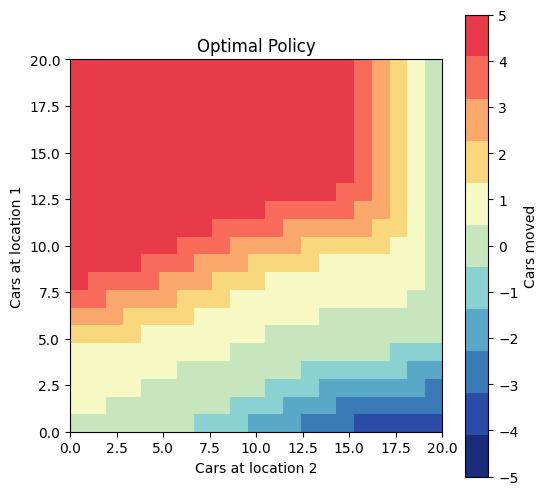

Start iteration:  2


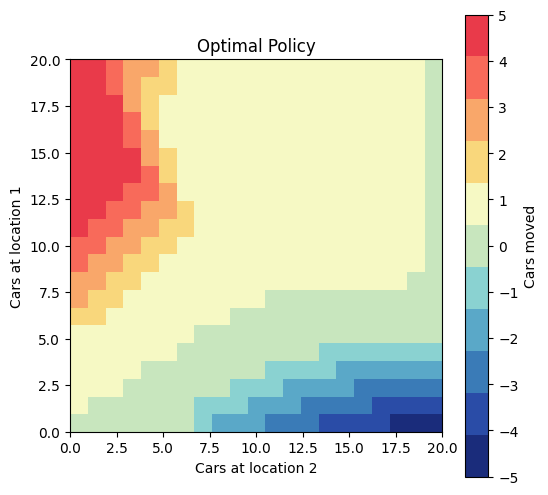

Start iteration:  3


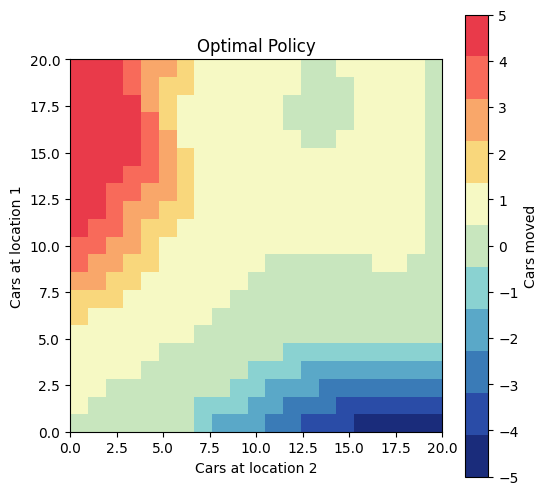

Start iteration:  4


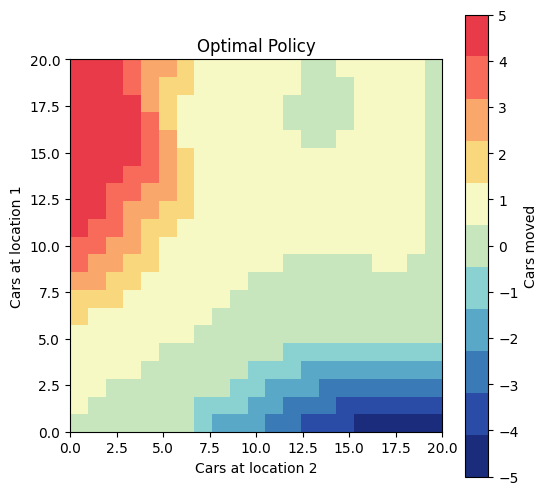

Start iteration:  5
Iteration complete!  [[362.84939145 372.6661153  382.33841282 391.70083121 400.60456382
  408.9695502  416.78178154 424.50549774 431.82176161 439.06213061
  445.76825441 452.27499628 458.34806702 463.85040134 469.1841839
  473.88880537 478.12233363 482.04261457 485.49074293 488.60716086
  491.49970177]
 [372.66731371 382.40594299 392.07833916 401.43982647 410.34103928
  418.7018792  426.50854813 433.82477519 441.06513662 447.77125609
  454.2774627  460.35053329 465.85207651 471.1858613  475.89048743
  480.12329056 484.04357593 487.49171079 490.60813793 493.50069155
  496.22195815]
 [382.40934994 392.08149232 401.45671297 410.81245503 419.70230063
  428.04563929 435.82915985 443.0695179  449.775635   456.28141271
  462.3544888  467.85511757 473.1889131  477.89355661 482.12527668
  486.04557889 489.49373663 492.61019405 495.50278716 498.22410457
  500.78101342]
 [391.79082445 401.46070482 410.81649002 419.70663492 428.43659
  436.74089511 444.47293167 451.65116052 458

In [9]:
iter_count = 1
while True:
    print("Start iteration: ", iter_count)
    policy_evaluation()
    if policy_improvement():
        break
    show_graph(policy)
    iter_count += 1